# GC Lottery Stats
Data from https://www.nps.gov/grca/planyourvisit/upload/{year}_Lottery_Statistics.pdf

TODO:
- add in data about number of points to see if people with more points apply on different days; how to hypothesis test the distribution of applicants with 1 point vs > 1 point vs > 5 points
- fit a seasonal model that we can then use to find minima and see if that comes to similar conclusion as the counting based method
    - check seasonality, etc

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

In [551]:
# load data and preprocess
df = pd.read_csv('grcaRiverLotteryData.csv')
df = df[df.lotteryTitle.str.contains('Main')]  # filter to main lotteries
df['date'] = df[[f'launchDatePref{i}_yyyy_mm_dd' for i in range(1,6)]].to_numpy().tolist()
df = df.explode('date')[['numberPoints', 'date']]
df = df.astype({
    'date' : np.datetime64,
    })
df = df.groupby('date').size().reset_index()
df.rename(columns={0:'num_applications'}, inplace=True)
df['year'] = pd.DatetimeIndex(df['date']).year
df['day_of_week'] = pd.DatetimeIndex(df['date']).day_name()
df['month'] = pd.DatetimeIndex(df['date']).month
df['week'] = pd.DatetimeIndex(df['date']).week

# load weather data
weather_df = pd.read_csv('weather_phantom.csv').astype({
    'DATE': np.datetime64
})
weather_df['month'] = pd.DatetimeIndex(weather_df['DATE']).month
weather_df['week'] = pd.DatetimeIndex(weather_df['DATE']).week

/var/folders/1s/xd8bsr_939sbp1zvyzxcp_4r0000gn/T/ipykernel_42895/3434596016.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = pd.DatetimeIndex(df['date']).week
/var/folders/1s/xd8bsr_939sbp1zvyzxcp_4r0000gn/T/ipykernel_42895/3434596016.py:21: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weather_df['week'] = pd.DatetimeIndex(weather_df['DATE']).week


# Data Exploration
Let's start by exploring our data. We've processed the data into number of applications per date. This isn't conventional time series data in the sense that it is a recording of number of occurrences of some "thing" at some time interval; however it is convenient to think of this way so we can try and identify seasonal patterns. If seasonal application patterns exist (e.g. application behavior in 2007 is similar to 2016 is similar to 2022) then I feel good about aggregating the data to compute application success probabilities. 

Let's start with a simple line plot of number of applications per date:

[Text(0.5, 1.0, 'Number of applications by date')]

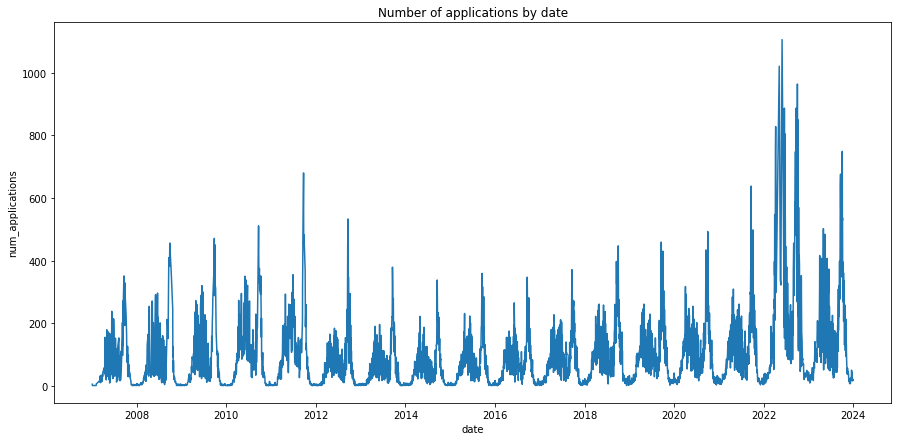

In [275]:
sns.lineplot(df, x='date', y='num_applications', ).set(title='Number of applications by date')

As we can see there appears to be a "seasonal trend" in applications - number of applications spike during the fall months and are much lower during the winter months. Intuitively this makes sense - fall trips (September/October) typically have pleasant weather (not too hot, not too cold) whereas winter trips can be very cold and have short days. I did a January trip in 2019 and I think the highs during the first week were sub-freezing; I had icicles forming off the tip of my helmet visor while paddling some rapids.

To more rigorously check if seasonal trends exist in the application behavior we can look at a couple different things:
1. Autocorrelation: This is a measure of how related changes in one random variable are with another; in a time series context we look at how changes in a random process at some time step $t$ are related to the process at $t-k$; $k$ is the number of lags.
2. Partial autocorrelation: This is similar to autocorrelation however it also controls for the effects of intermediate lags.
3. Augmented Dickey-Fuller (ADF) Test: This is a statistical test that can be leveraged for identifying stationarity within a random process; in this context we can use it to evaluate whether or not the probabilistic process we're modeling (application behaviors) is changing over time.

The main reason for this treatment is to try and validate the hypothesis that permit application dates are "cyclical" (e.g. people apply for similar launch dates in different years). If this hypothesis is true then I feel pretty good about computing probabilities "in aggregate" (e.g. taking averages of permit application dates and finding launch dates that give higher chances of winning).

Let's start by looking at the ADF test:

In [365]:
from statsmodels.tsa.stattools import adfuller

application_series = df.sort_values('date').num_applications

adf_statistic, pvalue, *_ = adfuller(application_series)
print(f'adf_statistic = {adf_statistic}')
print(f'pvalue = {pvalue}')

adf_statistic = -8.826308558704513
pvalue = 1.819607221278455e-14


ADF is testing the null hypothesis that the process is stationary. We observe a negative ADF test statistic and a very small p-value ($p << 0.05$) thus we reject the null hypothesis and say that the process is non-stationary. 

I think intuitively this makes sense because the number of applications per year is increasing:

[Text(0.5, 1.0, 'Number of grand canyon applications by year')]

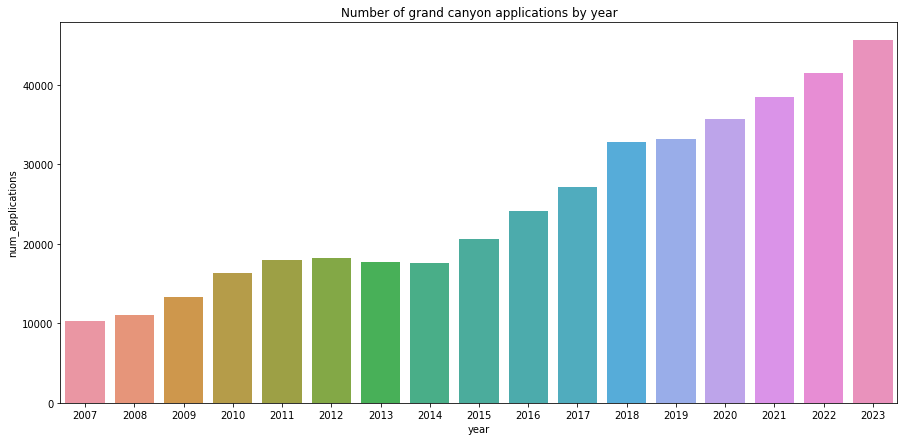

In [505]:
yearly_totals = df.groupby(['year']).sum().reset_index()
sns.barplot(yearly_totals, x='year', y='num_applications').set(title='Number of grand canyon applications by year')

I tried playing some games to scale the time series by number of applications for a given year and given year/month combination but continued to get results from the ADF test that rejected the null hypothesis. In terms of modeling this makes our life slightly more complicated because we can't use a typical ARMA model and now need to move into ARIMA model territory to account for the non-stationarity. 

Let's explore correlation/autocorrelation. By inspection we can see that the data appears to by cyclical on a yearly basis. Because the frequency of the time series is daily, we look at a yearly lag window such that $k=365$.

/Users/riomcmahon/opt/anaconda3/envs/ww_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


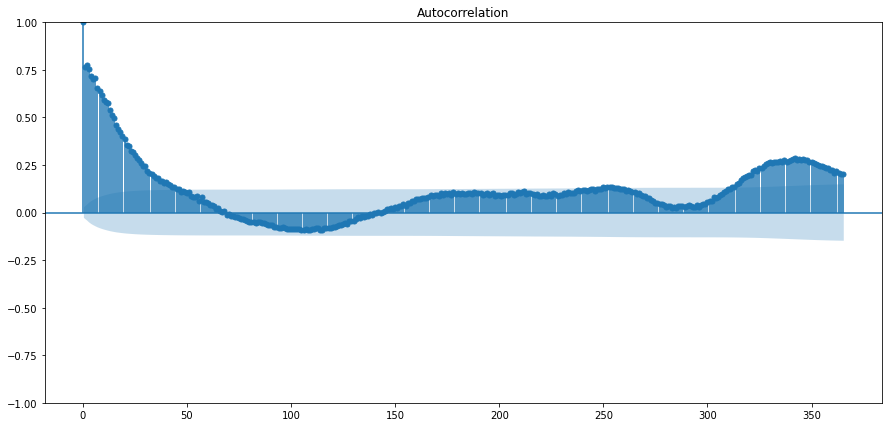

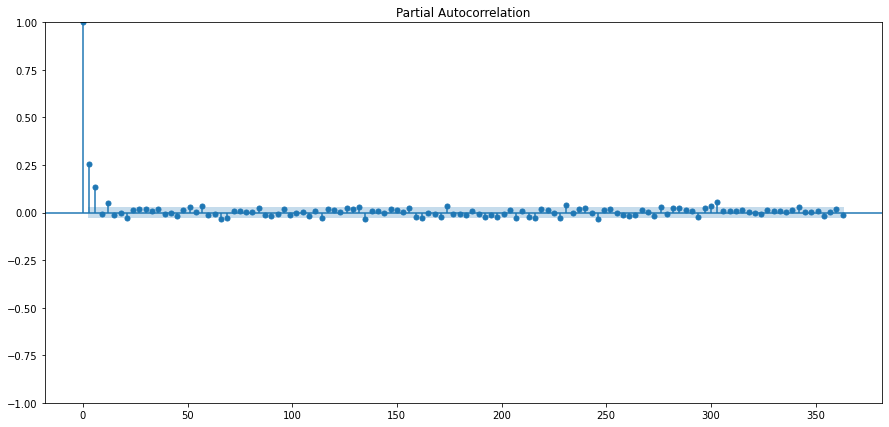

In [453]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(application_series, lags=365)
_ = plot_pacf(application_series, alpha=0.05, lags=np.arange(0,365, 3), zero=False)

We can make a couple interesting observations from the above plots. Note that any points lying within the blue shaded area are statistically insignificant. Additionally we plot every 3rd lag on the PACF plot so we can see what is statistically significant and what isn't. 
1. There appears to be statistically significant positive autocorrelation between permit applications for date $t$ and date $t-[320,365]$; the implication here is that permit applications ~1 year behind the current date in the series are positively correlated. More simply this means that the series tends to behave cyclically on a yearly basis. 
2. There appear to be a few partially autocorrelated points that are statistically significant; setting a confidence interval ($\alpha=0.001$) we see that lags $k\in{56, 226, 303, 316}$ are significant. We ignore lags where $k<20$ because ???

In [458]:
from statsmodels.tsa.stattools import pacf
pacf_array, confint = pacf(application_series, nlags=365, alpha=0.001)
pacf_df = pd.DataFrame({'pacf':pacf_array, 'confidence_interval_low':confint[:,0]-pacf_array, 'confidence_interval_high':confint[:,1]-pacf_array})
pacf_df_sig = pacf_df[(pacf_df.pacf < pacf_df.confidence_interval_low) | (pacf_df.pacf > pacf_df.confidence_interval_high)]
pacf_df_sig

,pacf,confidence_interval_low,confidence_interval_high
0,1.000000,0.000000,0.000000
1,0.765425,-0.047288,0.047288
2,0.456170,-0.047288,0.047288
3,0.254092,-0.047288,0.047288
4,0.091090,-0.047288,0.047288
5,0.049591,-0.047288,0.047288
6,0.132426,-0.047288,0.047288
12,0.050037,-0.047288,0.047288
14,-0.057797,-0.047288,0.047288
16,-0.063594,-0.047288,0.047288


<Axes: >

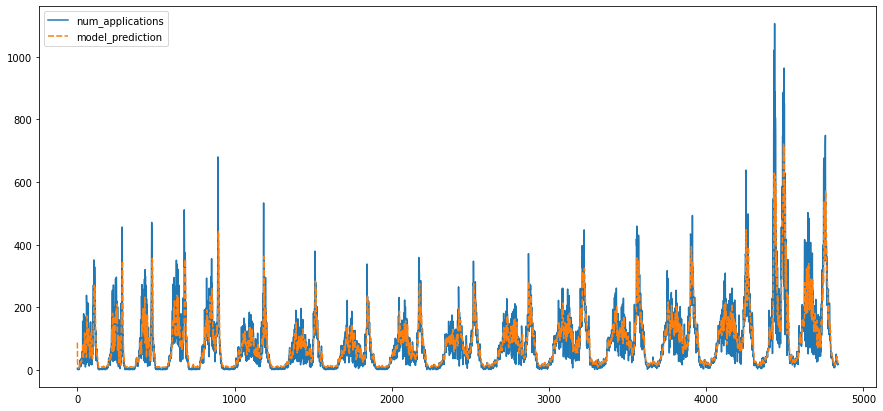

In [503]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(application_series, order=(10,0,0)).fit()

df['model_prediction'] = model.predict(start=0,)
sns.lineplot(df[['num_applications', 'model_prediction']])

In [ ]:
sns.barplot(df.groupby('day_of_week').sum().reset_index(), x='day_of_week', y='num_applications').set(title='net number of applications by day of week')

[Text(0.5, 1.0, 'net number of applications by month of year')]

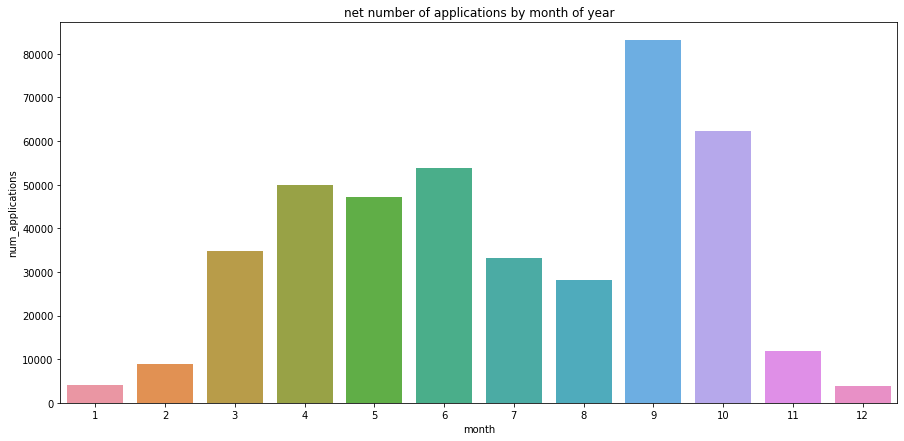

In [225]:
sns.barplot(df.groupby('month').sum().reset_index(), x='month', y='num_applications').set(title='net number of applications by month of year')

<Axes: xlabel='week', ylabel='Average Daily High (°F) at Phantom Ranch'>

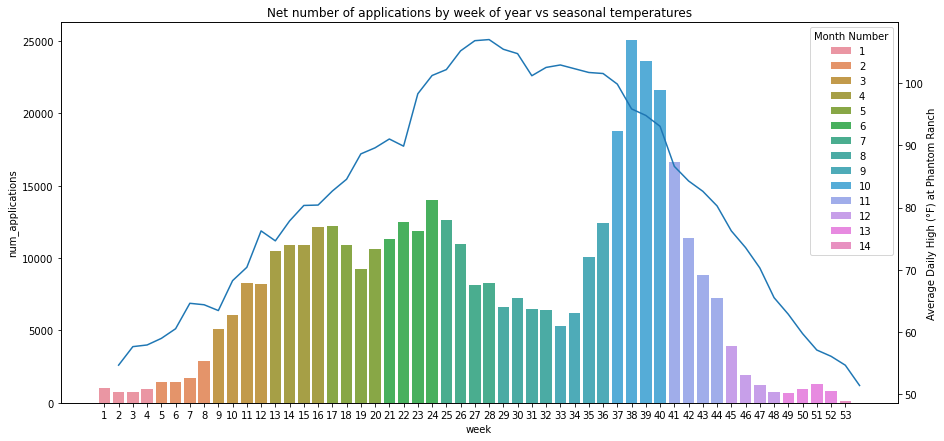

In [561]:
import math
import matplotlib.pyplot as plt

f, ax = plt.subplots()
week_sum_df = df.groupby('week').sum().reset_index()
week_sum_df['month'] =  (((week_sum_df.week -1) / 4) + 1).apply(math.floor)
sns.barplot(
    week_sum_df, 
    x='week', 
    y='num_applications', 
    hue='month',
    dodge=False
    # width=1,
    ).set(title='Net number of applications by week of year vs seasonal temperatures', )

ax.legend(ncol = 1, loc = 'upper right', title='Month Number')
ax2 = plt.twinx()
weather_avg = weather_df.groupby('week').mean().reset_index().rename(columns={'TMAX':'Average Daily High (°F) at Phantom Ranch'}) 
sns.lineplot(weather_avg, x='week', y='Average Daily High (°F) at Phantom Ranch', ax=ax2)

### doing some math
Based on the above we should break probabilities down based on day of week within a month. For example there is a much better chance of getting a permit in winter months is much higher but that has associated challenges (cold, short days etc). There is also a fair amount of variance intra-month (e.g. between weeks) so we should capture that as well.

Basically the question I want to answer is what day of the week for a given month will maximize my probability of winning the permit lottery. We also want to compare this to global probability of winning. Here we define monthly probability as number of 1/number of applications. When number of applications is small this probability increases and when it is large it decreases.

<Axes: xlabel='week', ylabel='probability'>

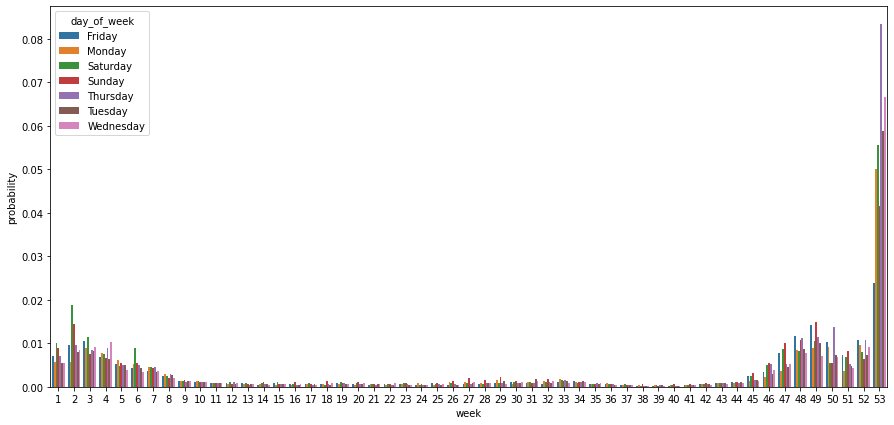

In [526]:
# prob_df = 
# df.groupby(['month', 'week']).sum().reset_index()
prob_df = df.groupby(['week', 'day_of_week']).sum().reset_index()
prob_df['probability'] = 1/prob_df.num_applications
# prob_df.sort_values('probability', ascending=False)
sns.barplot(prob_df, x='week', y='probability', hue='day_of_week')

In [530]:
prob_df.sort_values('probability', ascending=False)

,week,day_of_week,num_applications,year,month,model_prediction,probability
368,53,Thursday,12,6044,36,35.129597,0.083333
370,53,Wednesday,15,6044,36,35.997405,0.066667
369,53,Tuesday,17,6044,36,35.783323,0.058824
366,53,Saturday,18,4037,2,33.153837,0.055556
365,53,Monday,20,4035,24,25.438841,0.050000
...,...,...,...,...,...,...,...
259,38,Friday,4234,28201,126,3898.183817,0.000236
266,39,Friday,4243,28230,127,4109.817968,0.000236
278,40,Tuesday,4263,22186,106,3011.053874,0.000235
264,38,Tuesday,4715,20179,90,2808.349084,0.000212


<Axes: xlabel='day_of_week', ylabel='num_applications'>

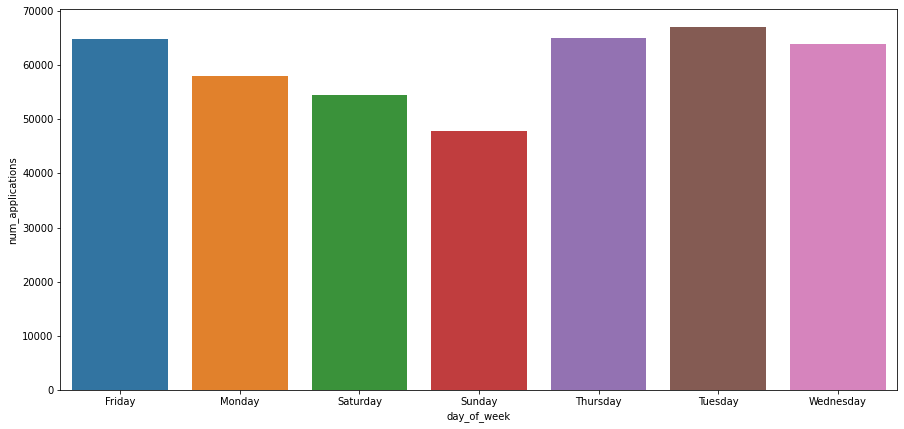

In [539]:
sns.barplot(df.groupby(['day_of_week']).sum().reset_index(), x='day_of_week', y='num_applications')

In [ ]:
week_sum_df = df.groupby('week').sum().reset_index()
df.join(
    week_sum_df[['week', 'num_applications']],
    on='week',
    rsuffix='_total',
    how='left'
)

/var/folders/1s/xd8bsr_939sbp1zvyzxcp_4r0000gn/T/ipykernel_42895/2389508317.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weather_df['week'] = pd.DatetimeIndex(weather_df['DATE']).week


,TMAX,month
week,,
1,54.611111,2.018519
2,57.594595,1.000000
3,57.862385,1.000000
4,58.925234,1.000000
5,60.478261,1.608696
6,64.576271,2.000000
7,64.342105,2.000000
8,63.407407,2.000000
9,68.227273,2.558559
